<a href="https://colab.research.google.com/github/jhhan0/self-study-ml/blob/main/tutorials/image-segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation
- Demonstrates how to do image segmentation, a task to find the shape of specific object in the input image. Then, the network assigns a class to each pixel of the image. Each pixel is given one of three sets: (1, pixel belongs to the pet), (2, pixel bordering the pet) and (3, pixel in surrounding)
- Full tutorial reference: https://www.tensorflow.org/tutorials/images/segmentation 


In [ ]:
pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-s0uaq5of
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-s0uaq5of
  Resolved https://github.com/tensorflow/examples.git to commit 0cc44f2e65499120bd2fdacf6f5be7eab7b416ef
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0cc44f2e65499120bd2fdacf6f5be7eab7b416ef_-py3-none-any.whl size=299718 sha256=5941072c4dcb8b4046e0ddb4c7a3864861b4d96a969c397172cb6b22dbbd6e3b
  Stored in directory: /tmp/pip-ephem-wheel-cache-zar3vnae/wheels/08/f6/82/53a5b86c72bceebba962022c76037c95a9b2912f0719e5b9d2
Failed to build tensorflow-examples
  Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel c

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.11.0


## Data Preprocessing

Download the Oxford-IIIT Pets Dataset from TensorFlow Datasets. 

In [ ]:
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteYQA6C3/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteYQA6C3/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


Define a function to normalize the image color values to the [0, 1] range. In addition, label the segmentation mask to {0, 1, 2} by subtracting 1 from the original {1, 2, 3} for ease of handling.

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
HEIGHT = 128
WIDTH = 128
CHANNEL = 3

def load_image(data):
  input_image = tf.image.resize(data['image'], (HEIGHT, WIDTH))
  input_mask = tf.image.resize(data['segmentation_mask'], (HEIGHT, WIDTH), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

Print out info for more information about the dataset.

In [ ]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    sp

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train_ds = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

## Perform a Data Augmentation

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=1):
    super().__init__()
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
train_batches = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().map(Augment()).prefetch(buffer_size=tf.data.AUTOTUNE)
test_batches = test_ds.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'Original Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

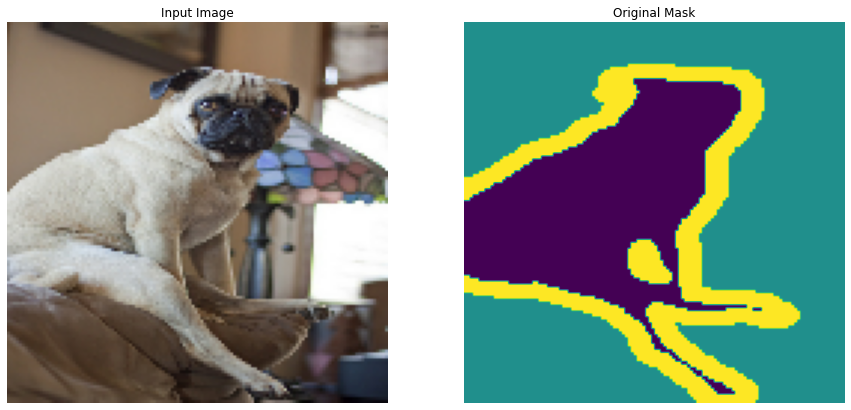

In [ ]:
for images, masks in train_batches.take(1):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Define the Model
In this tutorial, we are going to use the U-Net architecture which consists of an encoder (downsampler) and decoder (upsampler). For the encoder part, a pre-trained MobileNetV2 model will be used. For the decoder section, we will use the upsample block from pix2pix.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(HEIGHT, WIDTH, CHANNEL), include_top=False)

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [ ]:
layers_name = [
  'block_1_expand_relu',   # 64x64
  'block_3_expand_relu',   # 32x32
  'block_6_expand_relu',   # 16x16
  'block_13_expand_relu',  # 8x8
  'block_16_project',      # 4x4
]
# get outputs from layers mentioned above for skip connection
base_model_outputs = [base_model.get_layer(name).output for name in layers_name]
# create the feature extraction model
downsampler = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
downsampler.tranable = False

In [ ]:
upsampler = [
  pix2pix.upsample(filters=512, size=3),  # 4x4 -> 8x8
  pix2pix.upsample(256, 3),  # 8x8 -> 16x16
  pix2pix.upsample(128, 3),  # 16x16 -> 32x32
  pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

Define the complete U-Net architecture by combining both downsampler and upsampler.

In [ ]:
def u_net(output_channels:int):
  inputs = tf.keras.layers.Input(shape=(HEIGHT, WIDTH, CHANNEL))
  # downsampling
  down = downsampler(inputs)
  x = down[-1] # set the last feature map from down as x
  down = reversed(down[:-1]) # reverse the order

  # upsampling and concatenating the feature maps for the skip connections
  for up, skip in zip(upsampler, down):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # last layer: 64x64 -> 128x128
  last = tf.keras.layers.Conv2DTranspose(filters=output_channels, kernel_size=3, strides=2, padding="same")
  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = u_net(output_channels=3)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Plot the resulting U-Net architecture.

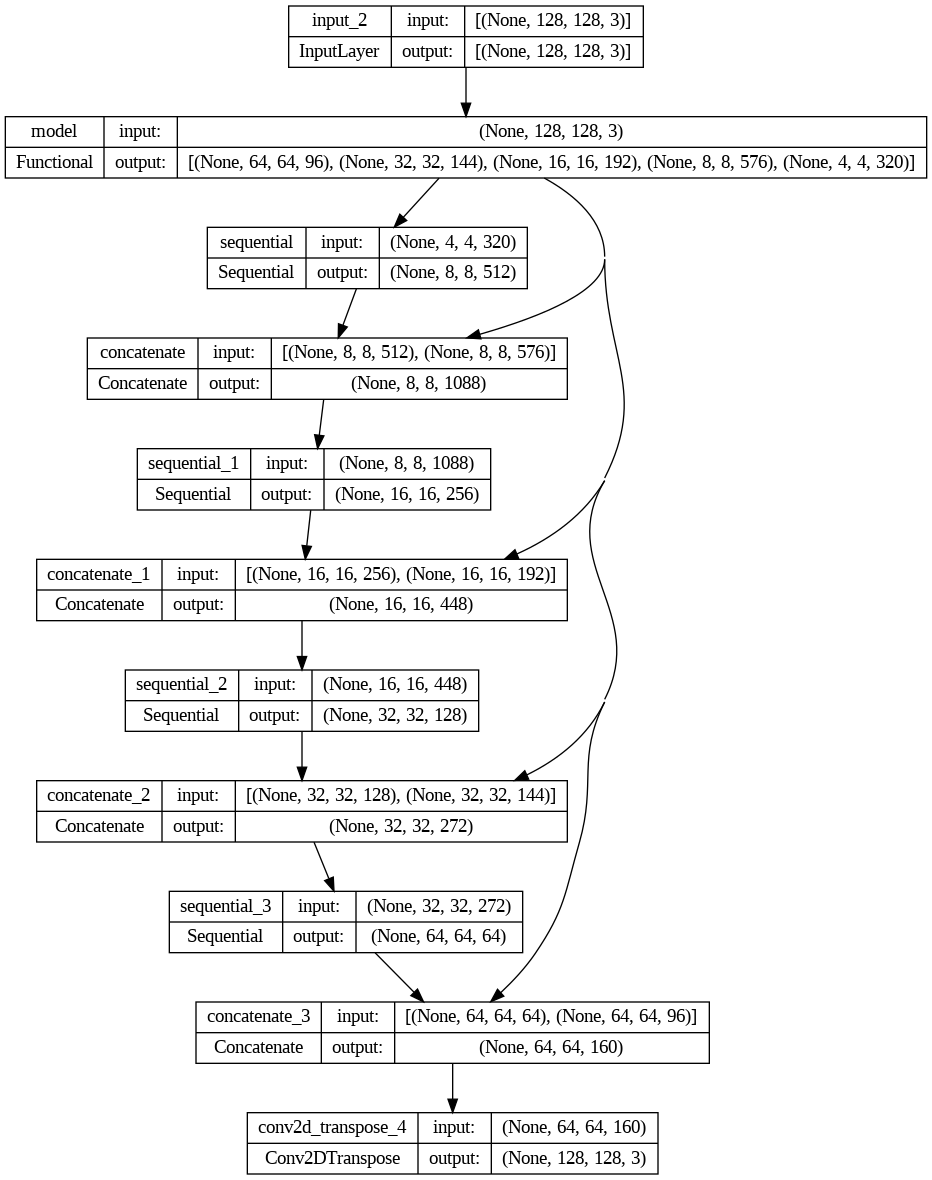

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Train the Model

Define two useful functions.

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print("\nSample Prediction after epoch {}\n".format(epoch+1))

1/1 [==============================] - 0s 24ms/step


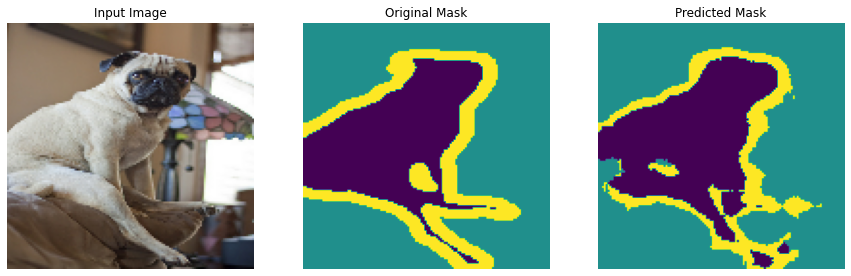


Sample Prediction after epoch 20

57/57 [==============================] - 13s 230ms/step - loss: 0.1026 - accuracy: 0.9566 - val_loss: 0.6003 - val_accuracy: 0.8363


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
history = model.fit(train_batches, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS, validation_data=test_batches, callbacks=[DisplayCallback()])

Plot Training loss vs. Validation loss of above 20 epochs training.

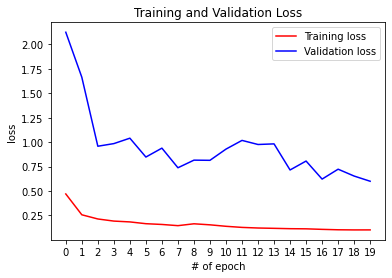

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('# of epoch')
plt.ylabel('loss')
plt.xticks(ticks=range(len(history.epoch)))
plt.legend()
plt.show()

## Make Predictions on the Test Dataset

2/2 [==============================] - 0s 45ms/step


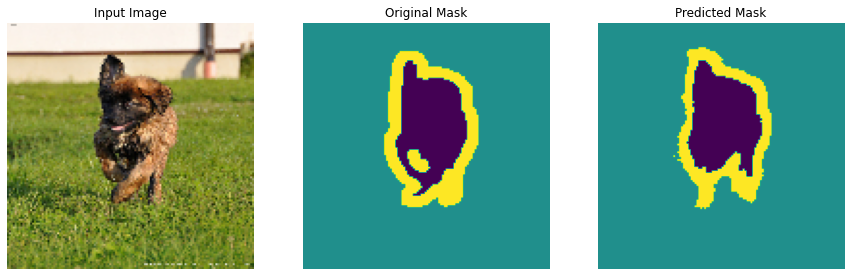

2/2 [==============================] - 0s 44ms/step


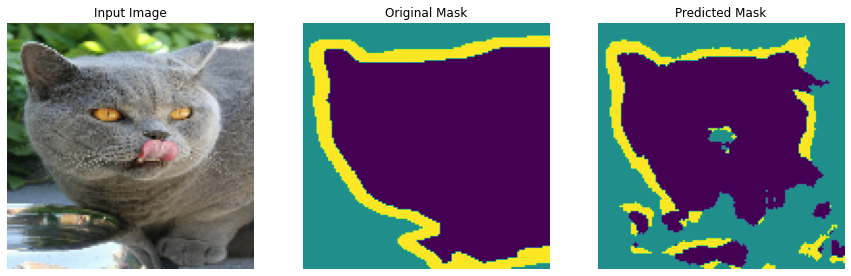

2/2 [==============================] - 0s 44ms/step


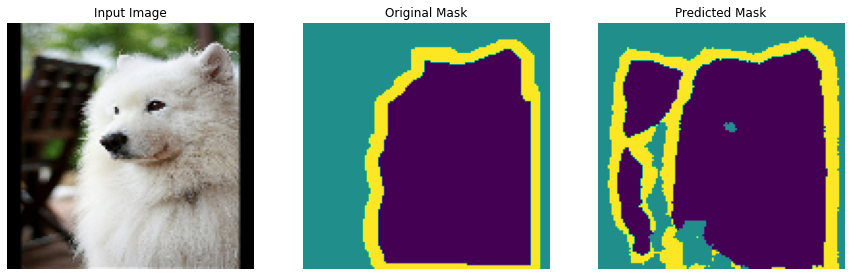

2/2 [==============================] - 0s 50ms/step


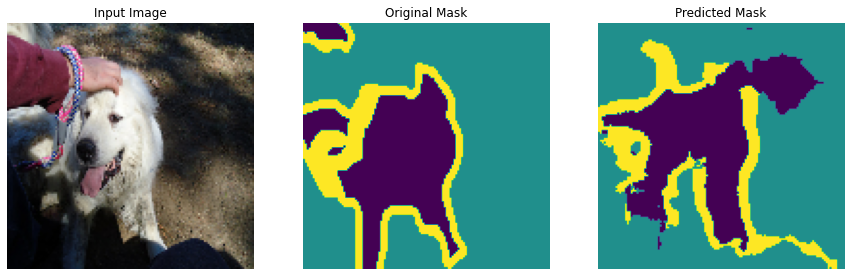

2/2 [==============================] - 0s 48ms/step


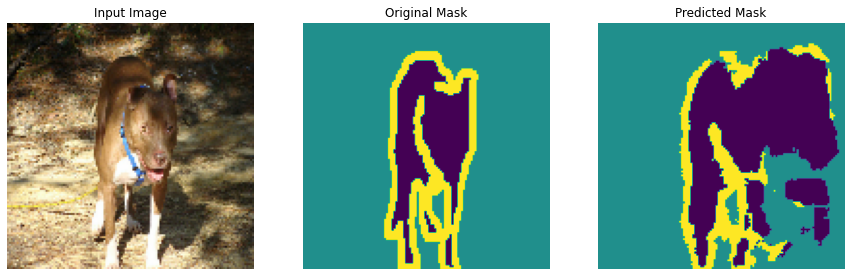

2/2 [==============================] - 0s 49ms/step


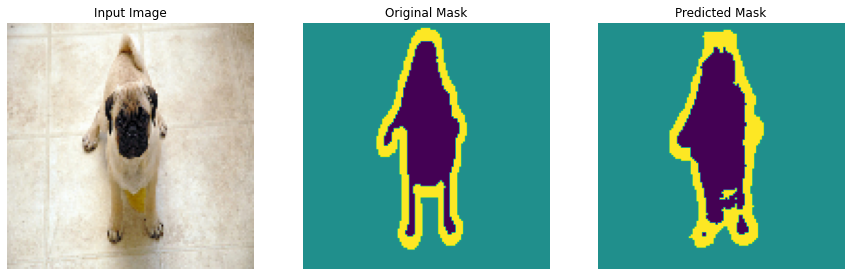

2/2 [==============================] - 0s 41ms/step


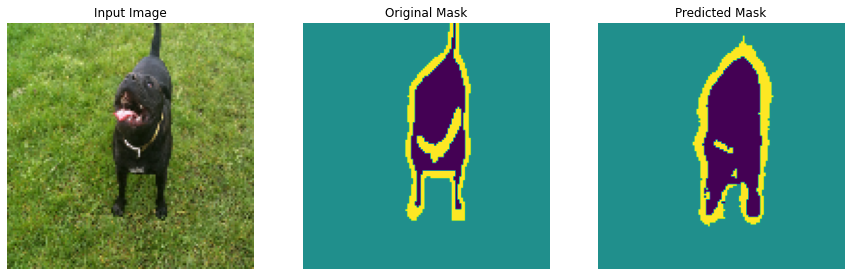

2/2 [==============================] - 0s 41ms/step


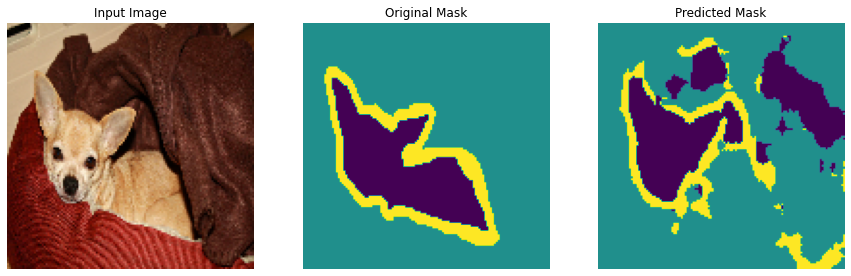

2/2 [==============================] - 0s 43ms/step


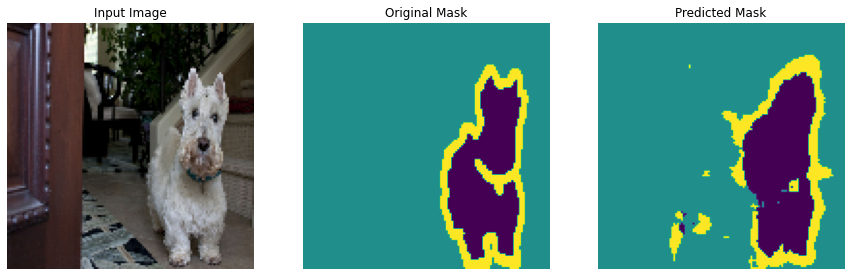

2/2 [==============================] - 0s 42ms/step


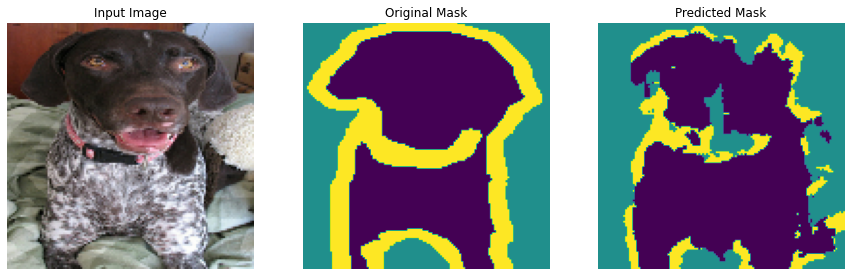

In [ ]:
show_predictions(test_batches, 10)

Except as otherwise noted, the content of this page is licensed under the Creative Commons Attribution 4.0 License, and code samples are licensed under the Apache 2.0 License. For details, see the Google Developers Site Policies. Java is a registered trademark of Oracle and/or its affiliates.